# simulator.ipynb
This is the main Jupyter notebook used to document progress and understanding of the current code library for the SPM.

The main library referenced in this notebook will be https://github.com/RichardLiuCoding/spmsimu/, used to simulate traces and retraces.

In [14]:
# Install the required libraries
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [15]:
# Import required components
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from spmsimu.simulator import *


Now that the basic components have been imported, we can assess the possibilities of the simulator in creating traces and retraces.


Generate the kernel for double tip, with tip1: [x_width, y_width, tip_height]
The two tips are separated by offset.
Everything is in the unit of pixels.



array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], shape=(256, 256))

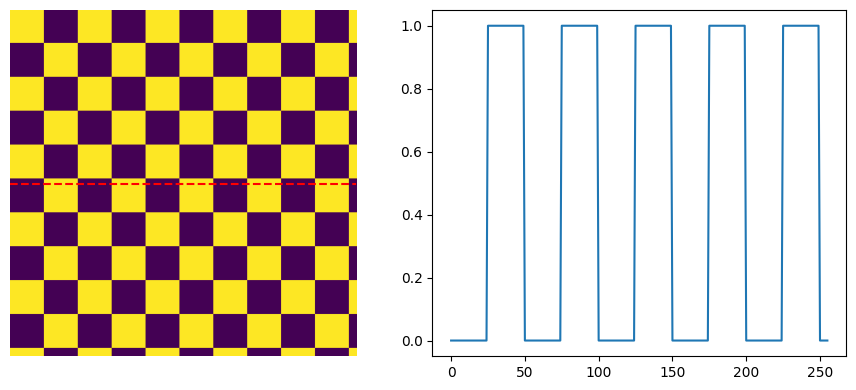

In [16]:
print(generate_doubletip_kernel.__doc__)
checkerboard = generate_pattern(nx=256, ny=256, pattern='checkerboard', num=10, show=True)

# The value of the generation is a 2D map with a singular value that determines its height.
checkerboard[:, :]

The function call to generate images uses the horizontal line (red-dashed) to show
hat you can define the region at which you scan.

This is important for the scanning probe microscope as it allows us to directly correlate
the relationship between what we "see" and what the data actually looks like.

For the simulator in this case, we know that we are working with 2D numpy arrays with a single
variable attached to each point in the array.

This leads us to having the ability to use **point-based estimation** for errors, if needed.

Instead, for now, let us define a way to pass in a function to define the image.

array([[  0.,   1.,   2., ..., 253., 254., 255.],
       [  0.,   1.,   2., ..., 253., 254., 255.],
       [  0.,   1.,   2., ..., 253., 254., 255.],
       ...,
       [  0.,   1.,   2., ..., 253., 254., 255.],
       [  0.,   1.,   2., ..., 253., 254., 255.],
       [  0.,   1.,   2., ..., 253., 254., 255.]], shape=(256, 256))

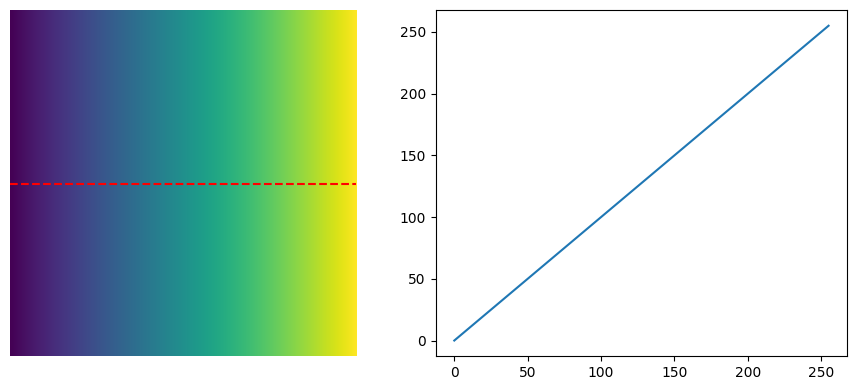

In [17]:
def generate_function_pattern(nx, ny, function = np.ceil, show = False):
    """
    This is a function to generate a map within a square region around the origin, given that
    a standard function or lambda is passed in.

    Inputs:
    nx - int:                   Number of pixels in x-direction
    ny - int:                   Number of pixels in y-direction
    function - lambda:          Function to be modeled around origin (center of image)
    show - bool:                If True, show the plot

    Output:
        pattern_map - ndarray:  2D map with generated pattern
    """
    output = np.zeros((nx, ny))

    # With the given default sin function, we can now modify the zeroed array to contain
    # height map values based on the effects of the function. This is just a double-for
    # loop to scan across the grid.
    for y in range(0, ny, 1):
        for x in range (0, nx, 1):
            output[x, y] = function(y)

    if show:
        fig,ax=plt.subplots(1,2,figsize=[9,4])
        ax[0].imshow(output)
        ax[0].axhline(nx//2, linestyle='--', color='red')
        ax[0].axis('off')
        ax[1].plot(output[nx//2,:])
        plt.tight_layout()

    return output
    
# Sample usage
generate_function_pattern(256, 256, function = lambda x: np.ceil(x), show = True)
    

So, now that we can generate any type of function, we can start to assess how errors in traces and retraces occur.

To do some research about the functionality of a SPM, we will look at some of these resources online:
+ https://www.nanophys.kth.se/nanolab/afm/icon/bruker-help/Content/SPM%20Training%20Guide/How%20an%20SPM%20Works.htm
+ https://www.semitracks.com/reference-material/failure-and-yield-analysis/failure-analysis-die-level/scanning-probe-microscopy.php
+ https://en.wikipedia.org/wiki/Scanning_probe_microscopy

## Probe and Scanner
The **probe** is the point of interface between the SPM and the sample material.
The **scanner** controls the precise position of the probe in relation to the surface (vertically and horizontally).

The scanner moves the probe over the material's surface in a precise pattern called the **raster** pattern. These are a series of zig-zag steps covering a square/rectangular area. This brings us to the tracing and retracing of the sample.

Data can be collected as the probe moves **left to right, during the trace**, and **right to left, during the retrace**. The discrepancies between these scanning modes is what we want to reduce and identify in this notebook.

The way that you can *experimentally optimize* the trace and retrace is by checking how they track during tapping mode. There are several methods that you can use to remedy issues with tracking or errors, such as :
+ Adjusting gains
+ Changing scan rate
+ Moving the set point
+ Changing integral/proportional gain

So what we want to do is to be able to first *detect* when a failure occurs with the retrace. We can now connect other repositories to allow us to use sample data.

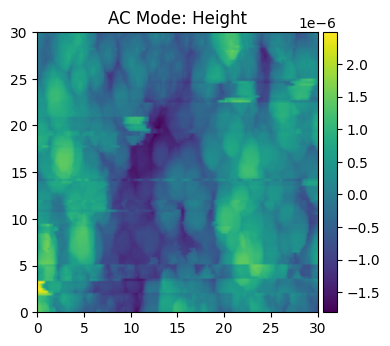

In [18]:
import aespm.tools as at

"""
You can either collect a series of .ibw files in a folder and load them using:
display_ibw_folder(folder, mode=None, key=['Height'], cmaps=None, paras=None, save=None, **kwargs):

Otherwise it is recommended that you use the single-ibw function:
"""
file = "sample_data/bad_images/PositionC_30Cs70M0000.ibw"
at.display_ibw(file, key = ['Height'])

## Relationship of Images to Data
What we want to do now is take an image file, as shown above, and transfer it into a datastructure that can be manipulated or viewed more easily.

Luckily, the given library allows us to take the data from any object read and store it as a numpy array.

In [19]:
from aespm import ibw_read

def create_test_dataframe(file):
    ibw = ibw_read(file)
    
    # Get dimensions directly from data shape
    if ibw.data.ndim == 3:
        side_y, side_x, channels = ibw.data.shape
    else:
        raise ValueError(f"Expected 3D data, got shape: {ibw.data.shape}")
    
    reshaped = ibw.data.reshape(-1, channels)
    
    rows, cols = np.meshgrid(range(side_y), range(side_x), indexing='ij')
    rows_flat = rows.flatten()
    cols_flat = cols.flatten()
    
    df = pd.DataFrame({
        'row': rows_flat,
        'col': cols_flat,
        ibw.channels[0]: reshaped[:, 0],
        ibw.channels[1]: reshaped[:, 1],
        ibw.channels[2]: reshaped[:, 2],
        ibw.channels[3]: reshaped[:, 3]
    })
    
    print(f"Size of data (rows): {len(ibw.z)}")
    print(f"Current mode: {ibw.mode}")
    print(f"Channels: {ibw.channels}")
    print(f"Size (meters): {ibw.size}")
    df.to_csv('image_data.csv', index=False)

    return df

# Example usage
file = "sample_data/bad_images/PositionC_30Cs70M0000.ibw"
df = create_test_dataframe(file)


Size of data (rows): 118
Current mode: AC Mode
Channels: ['Height', 'Amplitude', 'Phase', 'ZSensor']
Size (meters): 3e-05


Now we have an interface to bring data points into this environment. This will be useful for training any ML model that we need. Since I've already written a basic script to train ML models, we can easily use that to determine the best model in terms of prediction. But, the next section must cover **how to determine 'failure'** in these traces.

## Determining Failures at the Image Level
### Height
Sudden changes to the height indicate a failure. This can be introduced by noise and sudden steps.

We can compute **Laplacian gradient maps and line-to-line RMS differences** to check for sharp transitions in height. If we identify them, it is likely that we have a failure.

### Amplitude
Stable areas of an image are likely to have relatively constant amplitude. Failures may have streaking or ghosting in the image, i.e. where there are large variations in the amplitude of the sample, and/or dropouts where the tip may have lost contact.

We can write an algorithm to compute **standard deviation across rows or columns, and amplitude dropouts or sharp jumps**.

### Phase
Failures in phase likely result from noise and uniform low or high values.

We can try and validate these using **phase consistency among neighborhoods of data (such as a 3x3 window)**.

### Zsensor
Failures in the Zsensor often come from overcompensation from the piezo, such as oscillation or vertical banding.

We can **compare Zsensor - height residuals and look for large differences or line-wise averages**.



In [20]:
import os

def compute_channel_stats(values):
    mean = np.mean(values)
    std = np.std(values)
    median = np.median(values)
    value_range = np.ptp(values)
    entropy = -np.sum(np.histogram(values, bins=256, density=True)[0] *
                      np.log1p(np.histogram(values, bins=256, density=True)[0] + 1e-12))
    skew = mean - median

    return {
        'mean': mean,
        'std': std,
        'median': median,
        'range': value_range,
        'entropy': entropy,
        'skew': skew,
    }

def process_ibw_file(filepath):
    try:
        ibw = ibw_read(filepath)
        reshaped = ibw.data.reshape(-1, 4)
        stats = {}
        for i, ch in enumerate(ibw.channels):
            stats[ch] = compute_channel_stats(reshaped[:, i])
        return stats
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None

def collect_all_stats(folder):
    stats_by_channel = {}
    files = [f for f in os.listdir(folder) if f.endswith(".ibw")]

    for file in files:
        path = os.path.join(folder, file)
        stat_dict = process_ibw_file(path)
        if stat_dict:
            for channel, stats in stat_dict.items():
                stats['filename'] = file
                if channel not in stats_by_channel:
                    stats_by_channel[channel] = []
                stats_by_channel[channel].append(stats)
    
    # Add residual means from the "good" images to determine a threshold
    residual_means = []
    files = [f for f in os.listdir(folder) if f.endswith(".ibw")]
    for file in files:
        try:
            ibw = ibw_read(os.path.join(folder, file))
            residual = compute_zsensor_height_residual_mean(ibw)
            residual_means.append(residual)
        except Exception as e:
            print(f"Skipping {file} for residual calculation: {e}")

    return stats_by_channel

def compute_residual_threshold(folder):
    residual_means = []
    files = [f for f in os.listdir(folder) if f.endswith(".ibw")]
    for file in files:
        try:
            ibw = ibw_read(os.path.join(folder, file))
            residual = compute_zsensor_height_residual_mean(ibw)
            residual_means.append(residual)
        except Exception as e:
            print(f"Skipping {file} for residual calculation: {e}")
    
    residual_mean = np.mean(residual_means)
    residual_std = np.std(residual_means)
    return {
        'mean': residual_mean,
        'std': residual_std,
        'threshold': residual_mean + 3 * residual_std
    }

def compute_zsensor_height_residual_mean(ibw_obj):
    reshaped = ibw_obj.data.reshape(-1, 4)
    z = reshaped[:, ibw_obj.channels.index('ZSensor')]
    h = reshaped[:, ibw_obj.channels.index('Height')]
    return np.mean(np.abs(z - h))

def compute_thresholds(stats_by_channel, percentile=90):
    thresholds = {}
    for ch, stats_list in stats_by_channel.items():
        df = pd.DataFrame(stats_list)
        thresholds[ch] = {
            'std_thresh': np.percentile(df['std'], percentile),
            'range_thresh': np.percentile(df['range'], percentile),
            'entropy_thresh': np.percentile(df['entropy'], 100 - percentile),
            'skew_thresh': np.percentile(np.abs(df['skew']), percentile),
        }
    return thresholds

folder = "sample_data/good_images"
all_stats = collect_all_stats(folder)

# Save all stats if needed
for ch, stats in all_stats.items():
    pd.DataFrame(stats).to_csv(f"{ch}_stats.csv", index=False)

thresholds = compute_thresholds(all_stats)
thresholds['ZSensor_Height_Residual'] = compute_residual_threshold(folder)
import pprint
pprint.pprint(thresholds)

Error processing sample_data/good_images/PTO_AC_0006.ibw: index 4 is out of bounds for axis 1 with size 4
Skipping Cs50MA50approx_0035.ibw for residual calculation: 'ZSensor' is not in list
Skipping Cs50MA50approx_0045.ibw for residual calculation: 'ZSensor' is not in list
Skipping Cs50MA50approx_0044.ibw for residual calculation: 'ZSensor' is not in list
Skipping approx5050compos_0018.ibw for residual calculation: 'ZSensor' is not in list
Skipping PTO_AC_0006.ibw for residual calculation: 'ZSensor' is not in list
Skipping MBI_type_0020.ibw for residual calculation: 'ZSensor' is not in list
Skipping approx5050compos_0011.ibw for residual calculation: 'ZSensor' is not in list
Skipping approx5050compos_0012.ibw for residual calculation: 'ZSensor' is not in list
Skipping Cs50MA50approx_0005.ibw for residual calculation: 'ZSensor' is not in list
Skipping Cs50MA50approx_0035.ibw for residual calculation: 'ZSensor' is not in list
Skipping Cs50MA50approx_0045.ibw for residual calculation: 'ZS

Size of data (rows): 256
Current mode: AC Mode
Channels: ['Height', 'Amplitude', 'Phase', 'ZSensor']
Size (meters): 1e-05
=== THRESHOLDS ===
Height: {'std_thresh': np.float32(48.97406), 'range_thresh': np.float32(143.16818), 'entropy_thresh': np.float64(-2.0387449447037485), 'skew_thresh': np.float32(27.891098)}
Amplitude: {'std_thresh': np.float32(49.00329), 'range_thresh': np.float32(134.98392), 'entropy_thresh': np.float64(-2.0304525560439504), 'skew_thresh': np.float32(27.898043)}
Phase: {'std_thresh': np.float32(48.949284), 'range_thresh': np.float32(143.82047), 'entropy_thresh': np.float64(-2.0328003847187337), 'skew_thresh': np.float32(27.884197)}
ZSensor: {'std_thresh': np.float32(49.62182), 'range_thresh': np.float32(143.04382), 'entropy_thresh': np.float64(-2.015666890599321), 'skew_thresh': np.float32(28.091766)}
Potential: {'std_thresh': np.float32(23.995218), 'range_thresh': np.float32(137.2884), 'entropy_thresh': np.float64(-6.317330231952219), 'skew_thresh': np.float32(1

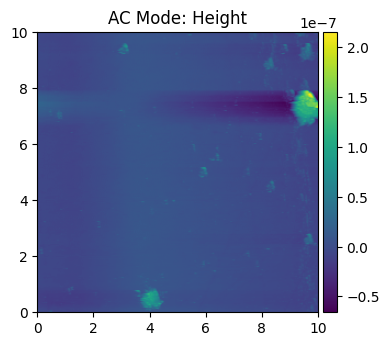

In [21]:
def check_failure_flags(height, amplitude, phase, zsensor):
    import numpy as np
    import pandas as pd

    results = {}

    def compute_features(channel):
        channel_flat = channel.flatten()
        mean = np.mean(channel_flat)
        std = np.std(channel_flat)
        median = np.median(channel_flat)
        range_val = np.ptp(channel_flat)
        entropy = -np.sum(np.histogram(channel_flat, bins=256, density=True)[0] *
                          np.log1p(np.histogram(channel_flat, bins=256, density=True)[0] + 1e-12))
        return mean, std, median, range_val, entropy

    # Height
    h_mean, h_std, h_median, h_range, h_entropy = compute_features(height)
    results['height_std_flag'] = h_std > thresholds['Height']['std_thresh']
    results['height_range_flag'] = h_range > thresholds['Height']['range_thresh']
    results['height_entropy_flag'] = h_entropy > thresholds['Height']['entropy_thresh']
    results['height_skew_flag'] = abs(h_mean - h_median) > thresholds['Height']['skew_thresh']

    # Amplitude
    a_mean, a_std, a_median, a_range, a_entropy = compute_features(amplitude)
    results['amplitude_std_flag'] = a_std > thresholds['Amplitude']['std_thresh']
    results['amplitude_range_flag'] = a_range > thresholds['Amplitude']['range_thresh']
    results['amplitude_entropy_flag'] = a_entropy > thresholds['Amplitude']['entropy_thresh']
    results['amplitude_skew_flag'] = abs(a_mean - a_median) > thresholds['Amplitude']['skew_thresh']

    # Phase
    p_mean, p_std, p_median, p_range, p_entropy = compute_features(phase)
    results['phase_std_flag'] = p_std > thresholds['Phase']['std_thresh']
    results['phase_range_flag'] = p_range > thresholds['Phase']['range_thresh']
    results['phase_entropy_flag'] = p_entropy > thresholds['Phase']['entropy_thresh']
    results['phase_skew_flag'] = abs(p_mean - p_median) > thresholds['Phase']['skew_thresh']

    # ZSensor
    z_mean, z_std, z_median, z_range, z_entropy = compute_features(zsensor)
    results['zsensor_std_flag'] = z_std > thresholds['ZSensor']['std_thresh']
    results['zsensor_range_flag'] = z_range > thresholds['ZSensor']['range_thresh']
    results['zsensor_entropy_flag'] = z_entropy > thresholds['ZSensor']['entropy_thresh']
    results['zsensor_skew_flag'] = abs(z_mean - z_median) > thresholds['ZSensor']['skew_thresh']

    # ZSensor - Height residual
    z_residual = np.abs(zsensor - height)
    z_residual_mean = np.mean(z_residual)
    results['zsensor_height_residual_flag'] = z_residual_mean > thresholds['ZSensor_Height_Residual']['threshold']

    # Overall fail flag
    results['overall_failure'] = any(flag for key, flag in results.items() 
                                    if key.endswith('_flag') and isinstance(flag, bool))

    def debug_thresholds_and_features(df, thresholds):
        # Check what your thresholds actually are
        print("=== THRESHOLDS ===")
        for ch, thresh in thresholds.items():
            if ch != 'ZSensor_Height_Residual':
                print(f"{ch}: {thresh}")
        
        # Check actual values from your bad image
        print("\n=== BAD IMAGE VALUES ===")
        h_mean, h_std, h_median, h_range, h_entropy = compute_features(df.Height.values)
        print(f"Height - std: {h_std:.3f} (thresh: {thresholds['Height']['std_thresh']:.3f})")
        print(f"Height - range: {h_range:.3f} (thresh: {thresholds['Height']['range_thresh']:.3f})")
        print(f"Height - entropy: {h_entropy:.3f} (thresh: {thresholds['Height']['entropy_thresh']:.3f})")
        print(f"Height - skew: {abs(h_mean-h_median):.3f} (thresh: {thresholds['Height']['skew_thresh']:.3f})")

    # Run this on your bad image
    debug_thresholds_and_features(df, thresholds)


    return results

# Convert pandas Series to numpy arrays before passing to the function
file = "sample_data/bad_images/BTO_AC_0002.ibw"
df = create_test_dataframe(file)

arr = check_failure_flags(
    df.Height.values,
    df.Amplitude.values,
    df.Phase.values,
    df.ZSensor.values
)

# Print results
for k, v in arr.items():
    print(f"{k}: {v}")

at.display_ibw(file, key = ['Height'])



In [22]:
class ScaledModel:
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler
    
    def predict_proba(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model.predict_proba(X_scaled)
    
    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model.predict(X_scaled)
    
    @property
    def feature_importances_(self):
        return self.model.feature_importances_

Training ML model...
Found 27 bad image files
Found 44 good image files
Skipping approx5050compos_0018.ibw - missing channel data
Skipping approx5050compos_0011.ibw - missing channel data
Skipping Cs50MA50approx_0044.ibw - missing channel data
Skipping approx5050compos_0012.ibw - missing channel data
Skipping MBI_type_0020.ibw - missing channel data
Skipping Cs50MA50approx_0035.ibw - missing channel data
Skipping Cs50MA50approx_0005.ibw - missing channel data
Skipping Cs50MA50approx_0045.ibw - missing channel data
Processing bad image: sample_data/bad_images/BSFO_AC_0006.ibw
Processing bad image: sample_data/bad_images/H_90Cs10MA_0000.ibw
Processing bad image: sample_data/bad_images/approx5050CsMA0016.ibw
Processing bad image: sample_data/bad_images/BSFO_AC_0007.ibw
Processing bad image: sample_data/bad_images/Cs50MA50approx_0024.ibw
Processing bad image: sample_data/bad_images/Cs50MA50approx_0032.ibw
Processing bad image: sample_data/bad_images/BSFO_AC_0005.ibw
Processing bad image: s

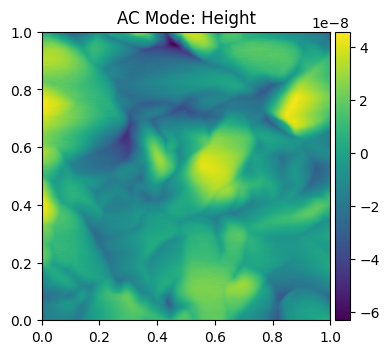

In [ ]:
def check_failure_flags(height, amplitude, phase, zsensor, thresholds, use_ml=True, ml_model=None):
    """
    Added thresholds as a parameter since it was referenced but not defined
    """
    import numpy as np
    import pandas as pd

    results = {}
    
    def compute_features(channel):
        channel_flat = channel.flatten()
        mean = np.mean(channel_flat)
        std = np.std(channel_flat)
        median = np.median(channel_flat)
        range_val = np.ptp(channel_flat)
        entropy = -np.sum(np.histogram(channel_flat, bins=256, density=True)[0] *
                         np.log1p(np.histogram(channel_flat, bins=256, density=True)[0] + 1e-12))
        return mean, std, median, range_val, entropy

    # Extract all features for all channels
    h_mean, h_std, h_median, h_range, h_entropy = compute_features(height)
    a_mean, a_std, a_median, a_range, a_entropy = compute_features(amplitude)
    p_mean, p_std, p_median, p_range, p_entropy = compute_features(phase)
    z_mean, z_std, z_median, z_range, z_entropy = compute_features(zsensor)
    
    # ZSensor - Height residual
    z_residual = np.abs(zsensor - height)
    z_residual_mean = np.mean(z_residual)
    
    # Traditional threshold-based flags
    results['height_std_flag'] = h_std > thresholds['Height']['std_thresh']
    results['height_range_flag'] = h_range > thresholds['Height']['range_thresh']
    results['height_entropy_flag'] = h_entropy > thresholds['Height']['entropy_thresh']
    results['height_skew_flag'] = abs(h_mean - h_median) > thresholds['Height']['skew_thresh']
    
    results['amplitude_std_flag'] = a_std > thresholds['Amplitude']['std_thresh']
    results['amplitude_range_flag'] = a_range > thresholds['Amplitude']['range_thresh']
    results['amplitude_entropy_flag'] = a_entropy > thresholds['Amplitude']['entropy_thresh']
    results['amplitude_skew_flag'] = abs(a_mean - a_median) > thresholds['Amplitude']['skew_thresh']
    
    results['phase_std_flag'] = p_std > thresholds['Phase']['std_thresh']
    results['phase_range_flag'] = p_range > thresholds['Phase']['range_thresh']
    results['phase_entropy_flag'] = p_entropy > thresholds['Phase']['entropy_thresh']
    results['phase_skew_flag'] = abs(p_mean - p_median) > thresholds['Phase']['skew_thresh']
    
    results['zsensor_std_flag'] = z_std > thresholds['ZSensor']['std_thresh']
    results['zsensor_range_flag'] = z_range > thresholds['ZSensor']['range_thresh']
    results['zsensor_entropy_flag'] = z_entropy > thresholds['ZSensor']['entropy_thresh']
    results['zsensor_skew_flag'] = abs(z_mean - z_median) > thresholds['ZSensor']['skew_thresh']
    
    results['zsensor_height_residual_flag'] = z_residual_mean > thresholds['ZSensor_Height_Residual']['threshold']
    
    # Traditional overall failure
    traditional_flags = [flag for key, flag in results.items() if key.endswith('_flag') and isinstance(flag, bool)]
    results['traditional_failure'] = any(traditional_flags)
    
    # Enhanced rule-based logic
    entropy_flags = [
        results.get('height_entropy_flag', False),
        results.get('amplitude_entropy_flag', False), 
        results.get('phase_entropy_flag', False),
        results.get('zsensor_entropy_flag', False)
    ]
    results['multiple_entropy_failure'] = sum(entropy_flags) >= 2

    proximity_scores = []
    proximity_details = {}
    
    channels_data = {
        'Height': (h_std, h_range, abs(h_mean - h_median)),
        'Amplitude': (a_std, a_range, abs(a_mean - a_median)), 
        'Phase': (p_std, p_range, abs(p_mean - p_median)),
        'ZSensor': (z_std, z_range, abs(z_mean - z_median))
    }
    
    for ch, (std_val, range_val, skew_val) in channels_data.items():
        if ch in thresholds:
            std_prox = std_val / thresholds[ch]['std_thresh'] if thresholds[ch]['std_thresh'] > 0 else 0
            range_prox = range_val / thresholds[ch]['range_thresh'] if thresholds[ch]['range_thresh'] > 0 else 0
            skew_prox = skew_val / thresholds[ch]['skew_thresh'] if thresholds[ch]['skew_thresh'] > 0 else 0
            
            proximity_scores.extend([std_prox, range_prox, skew_prox])
            proximity_details[ch] = {
                'std_proximity': std_prox,
                'range_proximity': range_prox, 
                'skew_proximity': skew_prox
            }
    
    avg_proximity = np.mean(proximity_scores) if proximity_scores else 0
    results['high_proximity_failure'] = avg_proximity > 0.80
    results['proximity_score'] = avg_proximity
    results['proximity_details'] = proximity_details
    
    # ML-based prediction
    if use_ml and ml_model is not None:
        # Create feature vector
        feature_vector = np.array([
            h_std, h_range, h_entropy, abs(h_mean - h_median),
            a_std, a_range, a_entropy, abs(a_mean - a_median),
            p_std, p_range, p_entropy, abs(p_mean - p_median),
            z_std, z_range, z_entropy, abs(z_mean - z_median),
            z_residual_mean
        ]).reshape(1, -1)
        
        try:
            # Get ML prediction
            ml_prob = ml_model.predict_proba(feature_vector)[0][1]  # Probability of being bad
            results['ml_failure_probability'] = ml_prob
            results['ml_failure'] = ml_prob > (0.65)
            
            # If it's a tree-based model, get feature importance for this prediction
            if hasattr(ml_model, 'feature_importances_'):
                feature_names = [
                    'height_std', 'height_range', 'height_entropy', 'height_skew',
                    'amplitude_std', 'amplitude_range', 'amplitude_entropy', 'amplitude_skew',
                    'phase_std', 'phase_range', 'phase_entropy', 'phase_skew',
                    'zsensor_std', 'zsensor_range', 'zsensor_entropy', 'zsensor_skew',
                    'residual_mean'
                ]
                results['feature_importance'] = dict(zip(feature_names, ml_model.feature_importances_))
                
        except Exception as e:
            print(f"ML prediction failed: {e}")
            results['ml_failure'] = False
            results['ml_failure_probability'] = 0.0
    else:
        results['ml_failure'] = False
        results['ml_failure_probability'] = 0.0
    
    # Count how many of the main failure modes are True (traditional, entropy, proximity, ML)
    sum_fails = sum([
        bool(results['traditional_failure']),
        bool(results['multiple_entropy_failure']),
        bool(results['high_proximity_failure']),
        bool(results['ml_failure'])
    ])

    results['overall_failure'] = sum_fails > 2
    
    # Store raw feature values for analysis
    results['raw_features'] = {
        'height': {'mean': h_mean, 'std': h_std, 'median': h_median, 'range': h_range, 'entropy': h_entropy},
        'amplitude': {'mean': a_mean, 'std': a_std, 'median': a_median, 'range': a_range, 'entropy': a_entropy},
        'phase': {'mean': p_mean, 'std': p_std, 'median': p_median, 'range': p_range, 'entropy': p_entropy},
        'zsensor': {'mean': z_mean, 'std': z_std, 'median': z_median, 'range': z_range, 'entropy': z_entropy},
        'residual_mean': z_residual_mean
    }
    
    return results


def train_ml_model(all_stats, bad_image_files, good_image_folder, ibw_read_func):
    """
    Train an ML model to distinguish good from bad images
    
    Parameters:
    - all_stats: your existing stats from good images
    - bad_image_files: list of file paths to bad images OR folder path
    - good_image_folder: folder containing good images
    - ibw_read_func: your ibw_read function (pass it as parameter)
    """
    import numpy as np
    import pandas as pd
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import cross_val_score, train_test_split
    from sklearn.preprocessing import StandardScaler
    import pickle
    import os
    
    print("Training ML model...")
    
    if isinstance(bad_image_files, str):
        # If it's a folder path, get all .ibw files from it
        if os.path.isdir(bad_image_files):
            bad_files = [os.path.join(bad_image_files, f) for f in os.listdir(bad_image_files) if f.endswith('.ibw')]
        else:
            bad_files = [bad_image_files]
    else:
        bad_files = bad_image_files
    
    print(f"Found {len(bad_files)} bad image files")
    
    # Prepare feature matrix and labels
    X = []
    y = []
    
    # Get all unique filenames from Height channel (they should all have the same files)
    if 'Height' in all_stats:
        unique_files = list(set(stats['filename'] for stats in all_stats['Height']))
        print(f"Found {len(unique_files)} good image files")
        
        for filename in unique_files:
            try:
                # Find stats for this filename in each channel
                h_stats = next((s for s in all_stats['Height'] if s['filename'] == filename), None)
                a_stats = next((s for s in all_stats['Amplitude'] if s['filename'] == filename), None)
                p_stats = next((s for s in all_stats['Phase'] if s['filename'] == filename), None)
                z_stats = next((s for s in all_stats['ZSensor'] if s['filename'] == filename), None)
                
                # Skip if any channel is missing
                if not all([h_stats, a_stats, p_stats, z_stats]):
                    print(f"Skipping {filename} - missing channel data")
                    continue
                
                # Get residual from all_stats if available
                residual = 0
                if 'ZSensor_Height_Residual' in all_stats:
                    residual_stats = next((s for s in all_stats['ZSensor_Height_Residual'] if s.get('filename') == filename), None)
                    if residual_stats:
                        residual = residual_stats.get('mean', 0)
                
                # Create feature vector
                features = [
                    h_stats['std'], h_stats['range'], h_stats['entropy'], h_stats['skew'],
                    a_stats['std'], a_stats['range'], a_stats['entropy'], a_stats['skew'],
                    p_stats['std'], p_stats['range'], p_stats['entropy'], p_stats['skew'],
                    z_stats['std'], z_stats['range'], z_stats['entropy'], z_stats['skew'],
                    residual
                ]
                
                X.append(features)
                y.append(0)  # Good image
                
            except Exception as e:
                print(f"Error processing good image {filename}: {e}")
    else:
        print("No 'Height' channel found in all_stats")
    
    for bad_file in bad_files:
        try:
            print(f"Processing bad image: {bad_file}")
            ibw = ibw_read_func(bad_file)       # Use the passed function
            reshaped = ibw.data.reshape(-1, 4)
            
            # Extract features for each channel (same as compute_channel_stats)
            features = []
            for i, ch in enumerate(['Height', 'Amplitude', 'Phase', 'ZSensor']):
                channel_data = reshaped[:, i]
                mean = np.mean(channel_data)
                std = np.std(channel_data)
                median = np.median(channel_data)
                range_val = np.ptp(channel_data)
                entropy = -np.sum(np.histogram(channel_data, bins=256, density=True)[0] *
                                np.log1p(np.histogram(channel_data, bins=256, density=True)[0] + 1e-12))
                skew = abs(mean - median)
                
                features.extend([std, range_val, entropy, skew])
            
            # Add residual (ZSensor - Height)
            z_data = reshaped[:, 3]             # ZSensor
            h_data = reshaped[:, 0]             # Height
            residual = np.mean(np.abs(z_data - h_data))
            features.append(residual)
            
            X.append(features)
            y.append(1)
            
        except Exception as e:
            print(f"Failed to process bad image {bad_file}: {e}")
            continue
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"Training data: {len(X)} samples, {X.shape[1]} features")
    print(f"Good images: {sum(y == 0)}, Bad images: {sum(y == 1)}")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    model.fit(X_train_scaled, y_train)
    
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    
    print(f"Training accuracy: {train_score:.3f}")
    print(f"Test accuracy: {test_score:.3f}")
    print(f"Cross-validation score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    feature_names = [
        'height_std', 'height_range', 'height_entropy', 'height_skew',
        'amplitude_std', 'amplitude_range', 'amplitude_entropy', 'amplitude_skew',
        'phase_std', 'phase_range', 'phase_entropy', 'phase_skew',
        'zsensor_std', 'zsensor_range', 'zsensor_entropy', 'zsensor_skew',
        'residual_mean'
    ]
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10))
    
    combined_model = ScaledModel(model, scaler)
    
    with open('image_quality_model.pkl', 'wb') as f:
        pickle.dump(combined_model, f)
    
    print("Model saved as 'image_quality_model.pkl'")
    
    return combined_model


def load_ml_model(model_path='image_quality_model.pkl'):
    """Load a trained ML model"""
    import pickle
    try:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        print(f"Loaded ML model from {model_path}")
        return model
    except FileNotFoundError:
        print(f"No ML model found at {model_path}. Train a model first or use use_ml=False")
        return None
    except Exception as e:
        print(f"Error loading ML model: {e}")
        return None


def enhanced_analysis(results):
    """Print detailed analysis of failure detection results"""
    print("=== ENHANCED FAILURE ANALYSIS ===")
    
    print(f"Traditional failure: {results['traditional_failure']}")
    print(f"Multiple entropy failure: {results['multiple_entropy_failure']}")
    print(f"High proximity failure: {results['high_proximity_failure']} (score: {results['proximity_score']:.3f})")
    print(f"ML failure: {results['ml_failure']} (probability: {results['ml_failure_probability']:.3f})")
    print(f"OVERALL FAILURE: {results['overall_failure']}")
    
    if 'proximity_details' in results:
        print("\n=== PROXIMITY TO THRESHOLDS ===")
        for ch, prox in results['proximity_details'].items():
            print(f"{ch}:")
            for metric, score in prox.items():
                status = "CLOSE" if score > 0.8 else "OK"
                print(f"  {metric}: {score:.3f} {status}")
    
    if 'feature_importance' in results:
        print("\n=== TOP CONTRIBUTING FEATURES (ML) ===")
        sorted_features = sorted(results['feature_importance'].items(), key=lambda x: x[1], reverse=True)
        for feature, importance in sorted_features[:8]:
            print(f"{feature}: {importance:.3f}")


bad_image_folder = 'sample_data/bad_images/' 
ml_model = train_ml_model(all_stats, bad_image_folder, "sample_data/good_images", ibw_read)

results = check_failure_flags(
    df.Height.values,
    df.Amplitude.values,
    df.Phase.values,
    df.ZSensor.values,
    thresholds,
    use_ml=True,
    ml_model=ml_model
)

ml_model = load_ml_model()

file = "sample_data/good_images/WTV_Loc019_0001.ibw"
df = create_test_dataframe(file)
at.display_ibw(file, ['Height'])
results = check_failure_flags(
    df.Height.values,
    df.Amplitude.values,
    df.Phase.values,
    df.ZSensor.values,
    thresholds,
    use_ml=True,
    ml_model=ml_model
)

enhanced_analysis(results)